/home/wagner/miniconda3/envs/xai4ecg/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


T_Wave_Amplitude
load model..
all parameters have same shape


100%|█████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.50it/s]


gradient


100%|███████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3376.46it/s]


lrp


100%|███████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3268.73it/s]


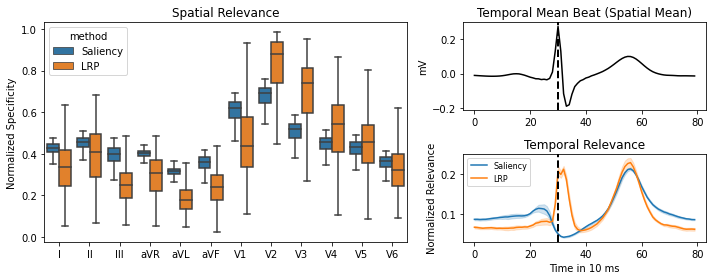

load model..
all parameters have same shape


100%|█████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.16s/it]


gradient


100%|███████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3115.83it/s]


lrp


100%|███████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3236.05it/s]


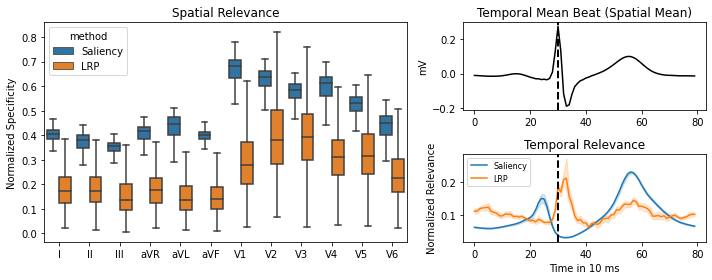

,model,task,metric,mean_score,std_score
0,lenet,T_Wave_Amplitude,r2,0.941185,0.006587
1,lenet,T_Wave_Amplitude,mae,0.035981,0.000841
2,xresnet,T_Wave_Amplitude,r2,0.940116,0.007210
3,xresnet,T_Wave_Amplitude,mae,0.036543,0.000698


In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../code'))
if module_path not in sys.path:
    sys.path.append(module_path)
import ecg_model as m
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, r2_score
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import attribute_signals as attr
import copy
import torch
import utils
from torch import nn
import seaborn as sns

if False:
    tasks = ['P_Wave_Amplitude',  'R_Peak_Amplitude',  'T_Wave_Amplitude']
    model_types = ['xresnet', 'lenet', 'resnet']
    methods = ['gradcam','gradient', 'lrp', 'ig']
else:
    tasks = ['T_Wave_Amplitude']
    model_types = ['lenet', 'xresnet']
    methods = ['gradient', 'lrp']

leads = np.array(['I','II','III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
n_bootstraps = 10
batch_size=32
n_samples = 1000
with_eval = True

res_dic = {'model':[], 'task':[], 'metric':[], 'mean_score':[], 'std_score':[]}
for task in tasks:
    print(task)
    X,Y,df = utils.get_regression_data(data_path='../data/ptbxl/', addon_path='../addons/', task=task)
    X_test = X[df.strat_fold==10]
    y_test = Y[df.strat_fold==10]
    df_test = df[df.strat_fold==10]
    
    num_classes = Y.shape[-1]
    ridxs = range(len(X_test))
    ridxs = np.random.choice(range(len(X_test)),n_samples)
    
    for modeltype in model_types:

        model = m.load_model(modeltype, task, num_classes, path='../output/')

        if with_eval:
            r2s, maes = [],[]
            for j in tqdm(range(n_bootstraps)):
                bootstrap_sample = np.random.choice(range(len(X_test)), len(X_test))
                samples = X_test[bootstrap_sample]
                labels = y_test[bootstrap_sample]
                Y_ = []
                for i in range((len(samples)//batch_size)+1):
                    tmp = model.forward(torch.from_numpy(np.swapaxes(samples[i*batch_size:(i+1)*batch_size],1,2)).type(torch.float).to('cuda'))
                    tmp=tmp.cpu().detach().numpy()
                    Y_.append(tmp)
                Y_ = np.concatenate(Y_)
                r2 = r2_score(labels.flatten(), Y_.flatten())
                mae = mean_absolute_error(labels.flatten(), Y_.flatten())
                r2s.append(r2)
                maes.append(mae)

            res_dic['model'].append(modeltype)
            res_dic['model'].append(modeltype)
            res_dic['task'].append(task)
            res_dic['task'].append(task)
            res_dic['metric'].append('r2')
            res_dic['mean_score'].append(np.mean(r2s))
            res_dic['std_score'].append(np.std(r2s))
            res_dic['metric'].append('mae')
            res_dic['mean_score'].append(np.mean(maes))
            res_dic['std_score'].append(np.std(maes))
        
        A,B = [],[]
        for method in methods:
            print(method)
            A2 = []
            B2 = []
            for cidx in range(len(leads)):
                # spatial
                Ai = attr.attribute_signals(model, X_test[ridxs], [cidx]*len(ridxs), Y.shape[-1], modeltype, method, batch_size=32)
                Aii = np.linalg.norm(Ai, axis=1)
                A2.append(Aii)

                # temporal
                normed_beats = utils.get_beats(Ai, df_test.iloc[ridxs] ,0, 1000, t_before=30, t_after=50)
                normed_beats = np.linalg.norm(normed_beats, axis=-1)
                B2.append(normed_beats)
            A2 = np.array(A2)
            B2 = np.array(B2)
            A.append(A2)
            B.append(B2)
        A = np.array(A)
        B = np.array(B)

        spatial_dic = {
            'specificity':[],
            'lead':[],
            'method':[]
        }
        for i, Ai in enumerate(A):
            for cidx in range(len(leads)):
                ai = Ai[cidx]
                for aii in ai:
                    spatial_dic['specificity'].append(aii[cidx]/np.linalg.norm(aii))
                    spatial_dic['lead'].append(leads[cidx])
                    spatial_dic['method'].append(methods[i])
        sdf = pd.DataFrame(spatial_dic)

        temporal_dic = {
            'relevance':[],
            'time':[],
            'method':[]
        }
        for i, Bi in enumerate(B):
            for cidx in range(len(leads)):
                median_b = np.mean(Bi[cidx],axis=0)
                median_b /= np.linalg.norm(median_b)
                for ti, bi in enumerate(median_b):
                    temporal_dic['relevance'].append(bi)
                    temporal_dic['time'].append(ti)
                    temporal_dic['method'].append(methods[i])
        tdf = pd.DataFrame(temporal_dic)

        rename_dic = {
            'gradcam':'Grad-CAM',
            'gradient':'Saliency',
            'lrp':'LRP',
            'ig':'IG',
        }
        tdf.method = tdf.method.apply(lambda x: rename_dic[x])
        sdf.method = sdf.method.apply(lambda x: rename_dic[x])

        beats = utils.get_beats(X_test[ridxs], df_test.iloc[ridxs], t_before=30, t_after=50)

        fig, axarr = plt.subplot_mosaic([['left','upper right'],
                                       ['left','lower right']],
                                      figsize=(10,4), layout="constrained",gridspec_kw=dict(width_ratios=[1.5, 1]))

        sns.boxplot(data=sdf, x="lead", y="specificity", hue="method", ax=axarr['left'], showfliers=False)
        axarr['left'].set_title('Spatial Relevance')
        axarr['left'].set_xlabel('')
        axarr['left'].set_ylabel('Normalized Specificity')

        sns.lineplot(data=tdf, x="time", y="relevance", hue="method", ax=axarr['lower right'])
        axarr['lower right'].axvline(30, c='k', linestyle='--', lw=2)
        axarr['lower right'].set_xlabel('Time in 10 ms')
        axarr['lower right'].set_title('Temporal Relevance')
        axarr['lower right'].set_ylabel('Normalized Relevance')
        axarr['lower right'].legend(fontsize=8)

        axarr['upper right'].plot(np.mean(np.mean(beats,axis=0), axis=-1), c='k')
        axarr['upper right'].set_ylabel('mV')
        axarr['upper right'].axvline(30, c='k', linestyle='--', lw=2)
        axarr['upper right'].set_title('Temporal Mean Beat (Spatial Mean)')

        plt.tight_layout()
        plt.savefig('sanitycheck_'+modeltype+'_'+task+'.pdf')
        plt.show()
        
res_df = pd.DataFrame(res_dic)
res_df  